# “Who’s that Pokémon?”: Predicting Pokémon Types and Legendary status from their Stats using k-nn classification. 

## Introduction

On February 27 2019, the 23rd anniversary of the Pokémon franchise, Nintendo announced its latest Pokémon games, which will introduce the eighth generation of Pokémon<sup>1</sup>. What unique Pokémon might we expect in this new game? The goal of this project is to train a k-nearest neighbours (k-nn) classification model that can predict a given Pokémon’s Type(s) as well as its Legendary status given its Generation Number (the generation of games that it debuted in) and Stats (a measure of a Pokémon’s capabilities). To train this model, we will use the Pokémon Stats Data Set, which contains the Names, Types, Generation, Stats, and Legendary-status of 800 Pokémon from six generations.

## Methods and Results

The independent/predictor (x) variables in our k-nn classification model are the Pokemon's 6 Stats - Hit Points, Attack, Defense, Special Attack, Special Defense, and Speed - as well as their Generation Number. We do not include the Total variable since it is merely the sum of the Pokemon's 6 Stats and negatively skew the results due to multicollinearity.

We will build three separate k-nn models using these predictor variables for the three dependent/response (y) variables : Type 1, Type 2, and Legendary-status.

To conduct the k-nn classification analysis, we split the data into an 80% training set and 20% testing set, making sure to set the seed to allow replication. We will use ten-fold cross-validation to determine the optimal value for k and the accuracy of the selected k-value for each of the classifiers. We will visualize the accuracy of the selected k-values in a line graph of accuracy against k-values. Using the optimal k-value, we will build our three classifiers and test it with the testing set to further determine the accuracy of each model.

Since some Pokemon only have one type (i.e. value for Type 2 is missing), we will recode missing values in the “Type 2” column as a 19th category “mono”, which implies that the Pokémon only has one Type. 

We considered two methods to building the k-nn classification model. Method 1 was to simply build the three separate k-nn models based on the 6 Stats and Generation number. 

Method 2 was to first build a k-nn classification model that would predict whether a Pokemon was either mono-type or dual-type, and then build separate k-nn classification models for the three outcome variables for mono-type and dual-type pokemon separately.

### Installing relevant packages and loading libraries

We begin by installing and loading the relevant packages and libraries needed for this analysis.

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(caret)
library(stringr)
install.packages("e1071", dependencies=TRUE, type='source')
library(e1071)
install.packages("GGally")
library(GGally)
install.packages("gridExtra")
library(gridExtra)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘testthat’

The following object is masked from ‘package:dplyr’:

    matches

The following object is masked from ‘package:purrr’:

    is_null

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

also installing the dependencies ‘cluster’, ‘mlbench’, ‘SparseM’, ‘slam’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘progress’, ‘reshape’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Updating HTML index of packages in '.Library'
M

### Load and Wrangle Data

We then load and read the data from github. From a quick look at the data, we need to wrangle and clean it to get it to a format necessary for classification. This process will involve: renaming the column names, removing unnecessary columns, adding new columns, and scaling the data.

In [2]:
pokemon <- read_csv("https://raw.githubusercontent.com/UBC-DSCI/datasets/master/pokemon/Pokemon.csv")
head(pokemon)

Parsed with column specification:
cols(
  `#` = col_integer(),
  Name = col_character(),
  `Type 1` = col_character(),
  `Type 2` = col_character(),
  Total = col_integer(),
  HP = col_integer(),
  Attack = col_integer(),
  Defense = col_integer(),
  `Sp. Atk` = col_integer(),
  `Sp. Def` = col_integer(),
  Speed = col_integer(),
  Generation = col_integer(),
  Legendary = col_character()
)


#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NA,309,39,52,43,60,50,65,1,False
5,Charmeleon,Fire,NA,405,58,64,58,80,65,80,1,False


In [3]:
#renaming the column headings to remove spaces between Type 1 and Type 2 and make the rest more understandable.
cleaning_data <- names(pokemon) <- c("Number","Name","Type_1", "Type_2", "Total", "Hit_Points", "Attack", "Defense", 
                                     "Special_Attack","Special_Defense", "Speed", "Generation", "Legendary")
# removing unnecessary columns
cleaned_pokemon <- pokemon %>% 
    select(-Number, -Name)
head(cleaned_pokemon)

Type_1,Type_2,Total,Hit_Points,Attack,Defense,Special_Attack,Special_Defense,Speed,Generation,Legendary
Grass,Poison,318,45,49,49,65,65,45,1,False
Grass,Poison,405,60,62,63,80,80,60,1,False
Grass,Poison,525,80,82,83,100,100,80,1,False
Grass,Poison,625,80,100,123,122,120,80,1,False
Fire,NA,309,39,52,43,60,50,65,1,False
Fire,NA,405,58,64,58,80,65,80,1,False


We created a Type_summary column to separate the data into Pokemon with one or two types for further classification to facilitate Method 2.

We also created dummy variables for the Generation columns as Gen_1, Gen_2... Gen_6 columns. The Generation column is split into six separate ones because it is a categorical variable and would not have been evenly spaced.

In [4]:
#creating new columns 
cleaned_pokemon2 <- cleaned_pokemon %>% 
    mutate(Type_sum =(Type_1 == Type_2),
    Gen_1 = as.numeric(Generation == 1),
    Gen_2 = as.numeric(Generation == 2),
    Gen_3 = as.numeric(Generation == 3),
    Gen_4 = as.numeric(Generation == 4),
    Gen_5 = as.numeric(Generation == 5),
    Gen_6 = as.numeric(Generation == 6),
    Type_summary = if_else(is.na(`Type_2`), "Mono", "Dual"))
                                        
head(n = 10, cleaned_pokemon2)

Type_1,Type_2,Total,Hit_Points,Attack,Defense,Special_Attack,Special_Defense,Speed,Generation,Legendary,Type_sum,Gen_1,Gen_2,Gen_3,Gen_4,Gen_5,Gen_6,Type_summary
Grass,Poison,318,45,49,49,65,65,45,1,False,FALSE,1,0,0,0,0,0,Dual
Grass,Poison,405,60,62,63,80,80,60,1,False,FALSE,1,0,0,0,0,0,Dual
Grass,Poison,525,80,82,83,100,100,80,1,False,FALSE,1,0,0,0,0,0,Dual
Grass,Poison,625,80,100,123,122,120,80,1,False,FALSE,1,0,0,0,0,0,Dual
Fire,NA,309,39,52,43,60,50,65,1,False,NA,1,0,0,0,0,0,Mono
Fire,NA,405,58,64,58,80,65,80,1,False,NA,1,0,0,0,0,0,Mono
Fire,Flying,534,78,84,78,109,85,100,1,False,FALSE,1,0,0,0,0,0,Dual
Fire,Dragon,634,78,130,111,130,85,100,1,False,FALSE,1,0,0,0,0,0,Dual
Fire,Flying,634,78,104,78,159,115,100,1,False,FALSE,1,0,0,0,0,0,Dual
Water,NA,314,44,48,65,50,64,43,1,False,NA,1,0,0,0,0,0,Mono


We then scale the predictor variables because k-nn classification measures the distance between points and variables on a larger scale would have a larger effect on the classification than variables on a smaller scale <sup>2</sup>.

In [6]:
#scaling relevant column data to normalize the features because different magnitudes in the attributes would
#bias the predictions. 
#Also removing unneccessary columns.
scaled_pokemon <- cleaned_pokemon2 %>%
    mutate(scaled_Total = scale(Total,center = FALSE), 
    scaled_Hit_Points = scale(Hit_Points, center = FALSE), 
    scaled_Attack = scale(Attack, center = FALSE),
    scaled_Defense = scale(Defense, center = FALSE),
    scaled_Special_Attack = scale(Special_Attack, center = FALSE),
    scaled_Special_Defense = scale(Special_Defense, center = FALSE),
    scaled_Speed = scale(Speed, center = FALSE),
    scaled_Gen_1 = scale(Gen_1, center = FALSE),
    scaled_Gen_2 = scale(Gen_2, center = FALSE),
    scaled_Gen_3 = scale(Gen_3, center = FALSE),
    scaled_Gen_4 = scale(Gen_4, center = FALSE),
    scaled_Gen_5 = scale(Gen_5, center = FALSE),
    scaled_Gen_6 = scale(Gen_6, center = FALSE)) %>%
    select(-Type_sum, -Generation,-Total, -Hit_Points, -Attack, -Defense, -Special_Attack, 
           -Special_Defense, -Speed, -Gen_1, -Gen_2, -Gen_3, -Gen_4, -Gen_5, -Gen_6)
head(scaled_pokemon)

Type_1,Type_2,Legendary,Type_summary,scaled_Total,scaled_Hit_Points,scaled_Attack,scaled_Defense,scaled_Special_Attack,scaled_Special_Defense,scaled_Speed,scaled_Gen_1,scaled_Gen_2,scaled_Gen_3,scaled_Gen_4,scaled_Gen_5,scaled_Gen_6
Grass,Poison,False,Dual,0.7041635,0.6092888,0.5734039,0.6109768,0.8137637,0.8426019,0.6061101,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,0.8968120,0.8123851,0.7255314,0.7855417,1.0015554,1.0370485,0.8081468,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,1.1625341,1.0831801,0.9595738,1.0349200,1.2519442,1.2963107,1.0775290,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,1.3839691,1.0831801,1.1702120,1.5336766,1.5273719,1.5555728,1.0775290,2.193913,0,0,0,0,0
Fire,NA,False,Mono,0.6842343,0.5280503,0.6085102,0.5361634,0.7511665,0.6481553,0.8754923,2.193913,0,0,0,0,0
Fire,NA,False,Mono,0.8968120,0.7853056,0.7489357,0.7231971,1.0015554,0.8426019,1.0775290,2.193913,0,0,0,0,0


## Exploratory Data Visualisations


We begin by visualising the difference between Legendary and non-Legendary Pokemon across the six different Stats. We find that Legendary Pokemon seem to have higher values across all Stats. This gives us confidence that our classification model will be able to predict a Pokemon's Legendary Status from its Stats accurately.

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

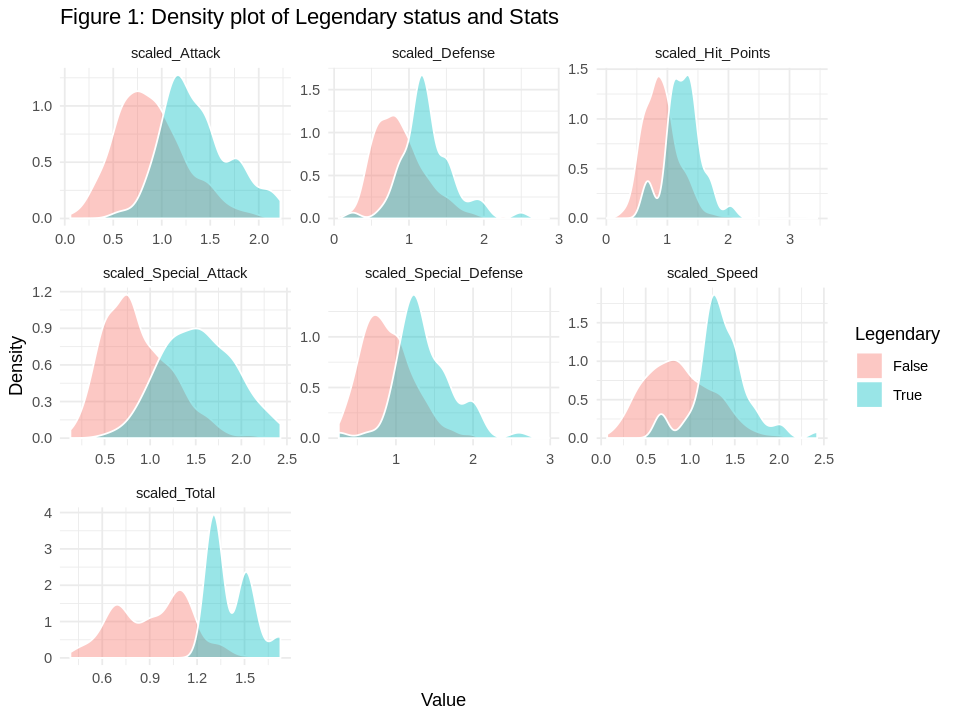

In [6]:
options(repr.plot.height = 6, repr.plot.width = 8)
scaled_pokemon %>%
    gather(key = 'stats', value = 'value', scaled_Total, scaled_Hit_Points, scaled_Attack, scaled_Defense, scaled_Special_Attack, scaled_Special_Defense, scaled_Speed) %>%
    ggplot(aes(value, fill = Legendary)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~stats, scales = 'free') +
        xlab('Value') +
        ylab('Density') +
        ggtitle('Figure 1: Density plot of Legendary status and Stats') +
        theme_minimal()

Our visualization of the count of Legendary Status on number of types and generation number, however, do not yield substantial differences on the predictor variables. This suggests that perhaps generation number might not be a good predictor variable to include in the model. It also suggests that Method 2, where we first predict whether a Pokemon is dual or mono-type before predicting Legendary Status separately for each group of Pokemon, might not be a good method since there are no substantial differences between mono- and dual-type Pokemon.

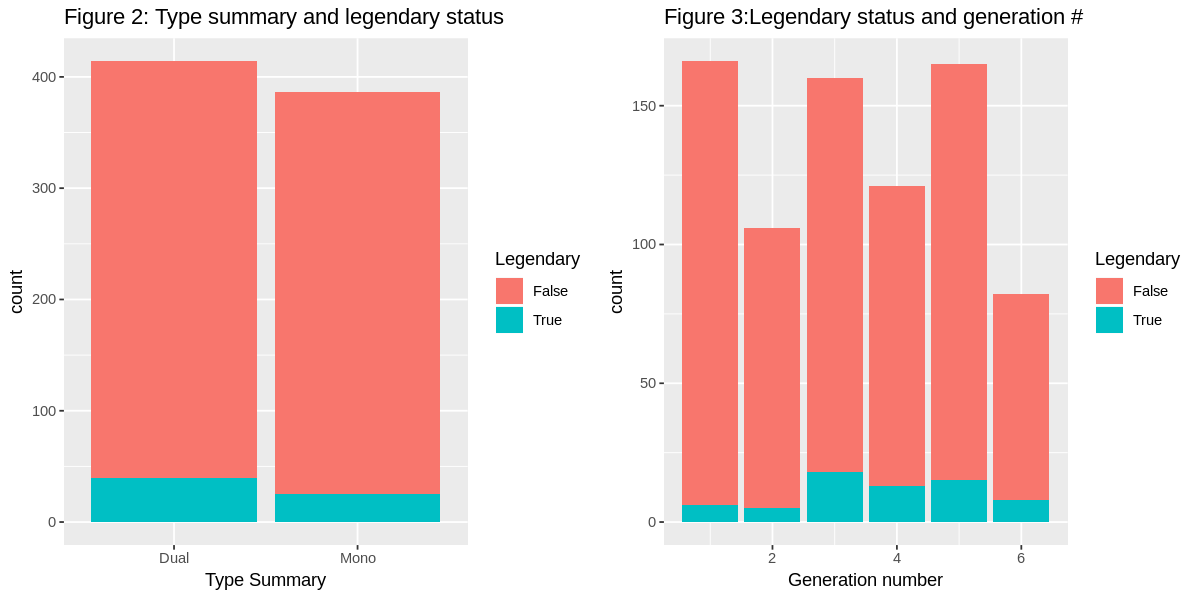

In [7]:
options(repr.plot.width= 10, repr.plot.height= 5)
viz1 <- scaled_pokemon %>%
        ggplot(aes(x= Type_summary, fill = Legendary)) +
        geom_bar() +
        labs(x= "Type Summary") +
        ggtitle("Figure 2: Type summary and legendary status")
viz2 <- cleaned_pokemon %>%
        ggplot(aes(x= Generation, fill = Legendary)) +
        geom_bar() +
        labs(x= "Generation number") +
        ggtitle("Figure 3:Legendary status and generation #")
grid.arrange(viz1, viz2, ncol = 2)

Our suspicions about the weakness of Method 2 are confirmed when we visualise the difference between mono- and dual-type Pokemon based on their Stats. We find that there is signficant overlap between these two groups of Pokemon across all 6 Stats, with no discernable difference. Thus, a classification model that classifies mono- and dual-type Pokemon will not be accurate. Furthermore, separate models that classify Legendary Status, Type 1, and Type 2 for mono- and dual-type Pokemon might not necessarily be better because there are no clear differences between the two models. 

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

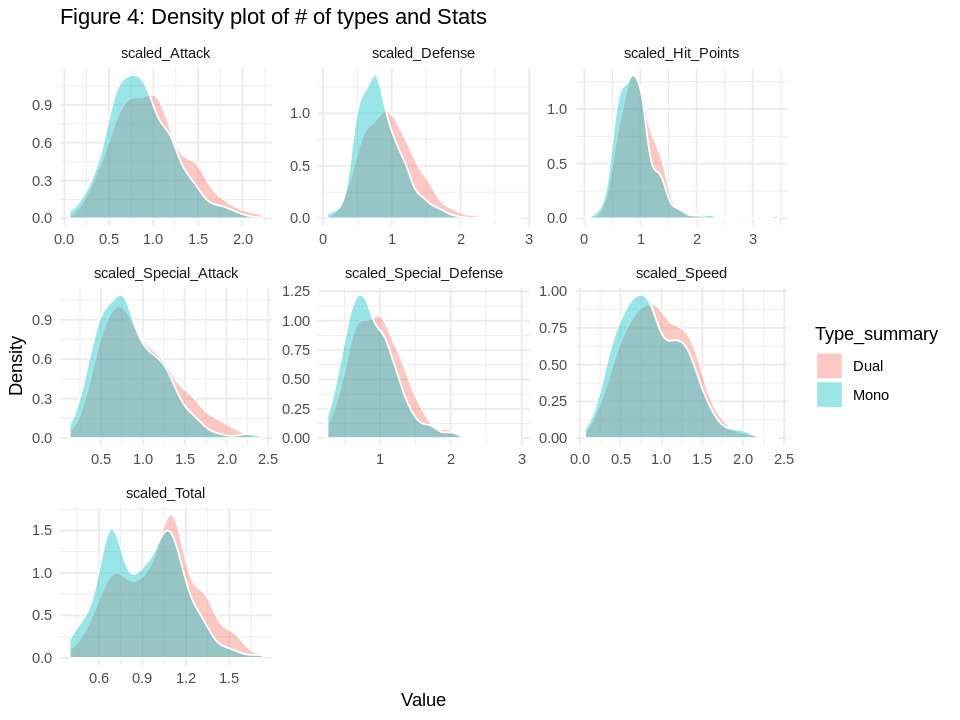

In [8]:
options(repr.plot.height = 6, repr.plot.width = 8)
scaled_pokemon %>%
    gather(key = 'stats', value = 'value', scaled_Total, scaled_Hit_Points, scaled_Attack, scaled_Defense, scaled_Special_Attack, scaled_Special_Defense, scaled_Speed) %>%
    ggplot(aes(value, fill = Type_summary)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~stats, scales = 'free') +
        xlab('Value') +
        ylab('Density') +
        ggtitle('Figure 4: Density plot of # of types and Stats') +
        theme_minimal()

Finally, our visualizations of Type 1 and Type 2 based on Generation number suggests that our classification models might not be very accurate since there are 19 different possible outcomes that all seem to share similar attribute/ Stat values. 

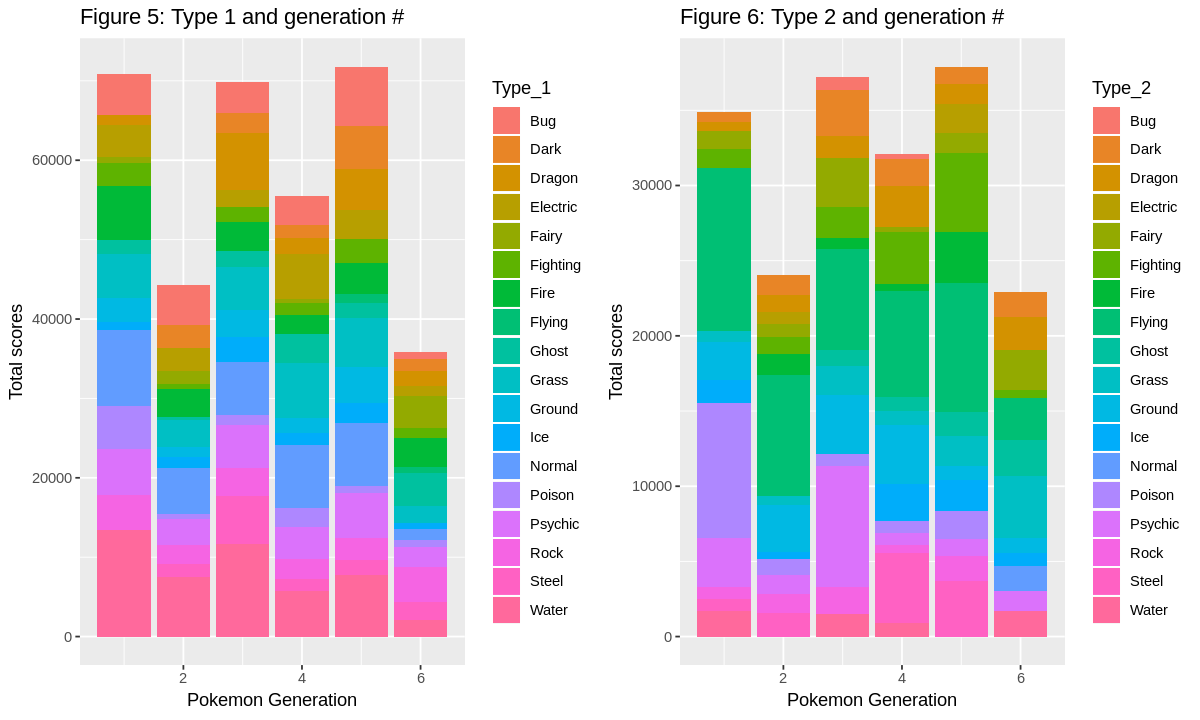

In [10]:
options(repr.plot.width= 10, repr.plot.height= 6)
viz3 <- cleaned_pokemon %>%
        ggplot(aes(x= Generation, y = Total, fill = Type_1)) +
        geom_bar(stat = "identity") +
        labs(x= "Pokemon Generation",
            y = "Total scores")+
            ggtitle("Figure 5: Type 1 and generation #")

viz4 <- cleaned_pokemon %>% 
        filter(!is.na (Type_2)) %>%
        ggplot(aes(x= Generation, y = Total, fill = Type_2)) +
        geom_bar( stat= "identity") +
        labs(x= "Pokemon Generation",
            y = "Total scores")+
            ggtitle("Figure 6: Type 2 and generation #")

grid.arrange(viz3, viz4, ncol = 2)

Thus, from our visualizations, we anticipate that our classification models for Legendary Status will be much more accurate than the classification models for Type 1 and Type 2. We also find that we have to examine the usefulness of including Generation number in our models more closely. 

## Models

Based on our visualizations and initial modelling, we found that Method 2 does not improve the accuracy as compared to Method 1. Thus, we choose to focus on Method 1 to answer our research question. 

We present two models: Model 1 uses all the predictor variables stated thus far - Pokemon's Stats and Generation Number. Model 2 drops Generation Number to see if accuracy improves. 

### Model 1: Training k-nn classification model on Stats and Generation Number 

In [11]:
#knn using full data (model 1)
set.seed(151)
training_rows <- scaled_pokemon %>%
    select(Legendary) %>%
    unlist() %>%
    createDataPartition(p=0.80, list=FALSE)

scaled_pokemon$Type_2[is.na(scaled_pokemon$Type_2)] <- 'Mono'

scaled_pokemon <- scaled_pokemon %>%
    mutate(Legendary=as.factor(Legendary)) %>%
    mutate(Type_1=as.factor(Type_1)) %>%
    mutate(Type_2=as.factor(Type_2))

X_train <- scaled_pokemon %>% 
    select(scaled_Hit_Points, scaled_Attack, scaled_Defense, scaled_Special_Attack, 
           scaled_Special_Defense, scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3,
           scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% 
    slice(training_rows) %>% 
    data.frame()

Y_train_legendary <- scaled_pokemon %>% 
    select(Legendary) %>% 
    slice(training_rows) %>% 
    unlist()

Y_train_type1 <- scaled_pokemon %>% 
    select(Type_1) %>% 
    slice(training_rows) %>% 
    unlist()

Y_train_type2 <- scaled_pokemon %>% 
    select(Type_2) %>% 
    slice(training_rows) %>% 
    unlist()

X_test <- scaled_pokemon %>% 
    select(scaled_Hit_Points, scaled_Attack, scaled_Defense, scaled_Special_Attack, 
           scaled_Special_Defense, scaled_Speed, scaled_Gen_1, scaled_Gen_2, scaled_Gen_3,
           scaled_Gen_4, scaled_Gen_5, scaled_Gen_6) %>% 
    slice(-training_rows) %>% 
    data.frame()

Y_test_legendary <- scaled_pokemon %>% 
    select(Legendary) %>% 
    slice(-training_rows) %>%
    unlist()

Y_test_type1 <- scaled_pokemon %>% 
    select(Type_1) %>% 
    slice(-training_rows) %>% 
    unlist()

Y_test_type2 <- scaled_pokemon %>% 
    select(Type_2) %>% 
    slice(-training_rows) %>% 
    unlist()

ks <- data.frame(k=c(1,3,5,7,9,11,13,15,17,19,21,23,25))
train_control <- trainControl(method='cv', number=10)

In [12]:
head(scaled_pokemon)

Type_1,Type_2,Legendary,Type_summary,scaled_Total,scaled_Hit_Points,scaled_Attack,scaled_Defense,scaled_Special_Attack,scaled_Special_Defense,scaled_Speed,scaled_Gen_1,scaled_Gen_2,scaled_Gen_3,scaled_Gen_4,scaled_Gen_5,scaled_Gen_6
Grass,Poison,False,Dual,0.7041635,0.6092888,0.5734039,0.6109768,0.8137637,0.8426019,0.6061101,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,0.8968120,0.8123851,0.7255314,0.7855417,1.0015554,1.0370485,0.8081468,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,1.1625341,1.0831801,0.9595738,1.0349200,1.2519442,1.2963107,1.0775290,2.193913,0,0,0,0,0
Grass,Poison,False,Dual,1.3839691,1.0831801,1.1702120,1.5336766,1.5273719,1.5555728,1.0775290,2.193913,0,0,0,0,0
Fire,Mono,False,Mono,0.6842343,0.5280503,0.6085102,0.5361634,0.7511665,0.6481553,0.8754923,2.193913,0,0,0,0,0
Fire,Mono,False,Mono,0.8968120,0.7853056,0.7489357,0.7231971,1.0015554,0.8426019,1.0775290,2.193913,0,0,0,0,0


### Outcome 1: Legendary Status

k-Nearest Neighbors 

640 samples
 12 predictor
  2 classes: 'False', 'True' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 576, 577, 576, 576, 576, 576, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.9358864  0.54455400
   3  0.9390346  0.48972422
   5  0.9328335  0.40917424
   7  0.9343471  0.37470174
   9  0.9281212  0.31490593
  11  0.9312221  0.30935972
  13  0.9312221  0.24727733
  15  0.9249962  0.15552095
  17  0.9218952  0.07641799
  19  0.9187702  0.00000000
  21  0.9187702  0.00000000
  23  0.9187702  0.00000000
  25  0.9187702  0.00000000

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 3.

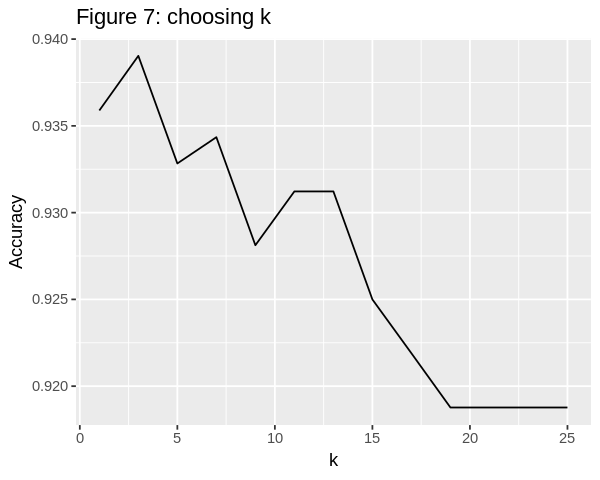

In [13]:
options(repr.plot.width= 5, repr.plot.height= 4)
set.seed(151)
knn_cv_legendary <- train(x=X_train, y=Y_train_legendary, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_legendary
knn_plot <- knn_cv_legendary$results %>%
    ggplot(aes(x=k,y=Accuracy)) +
    geom_line() +
    ggtitle('Figure 7: choosing k')
knn_plot

From the graph, we choose k=3 for the classification model for Legendary status.

In [14]:
set.seed(151)
final_k <- data.frame(k=3)
legendary_model <- train(x=X_train,y=Y_train_legendary,method='knn',tuneGrid=final_k)
legendary_predictions <- predict(legendary_model,X_test)
legendary_results <- confusionMatrix(legendary_predictions,Y_test_legendary)
legendary_results

Confusion Matrix and Statistics

          Reference
Prediction False True
     False   146    8
     True      1    5
                                         
               Accuracy : 0.9438         
                 95% CI : (0.8959, 0.974)
    No Information Rate : 0.9188         
    P-Value [Acc > NIR] : 0.1547         
                                         
                  Kappa : 0.5007         
 Mcnemar's Test P-Value : 0.0455         
                                         
            Sensitivity : 0.9932         
            Specificity : 0.3846         
         Pos Pred Value : 0.9481         
         Neg Pred Value : 0.8333         
             Prevalence : 0.9187         
         Detection Rate : 0.9125         
   Detection Prevalence : 0.9625         
      Balanced Accuracy : 0.6889         
                                         
       'Positive' Class : False          
                                         

Model 1 produces a test accuracy of 0.9438 when predicting Legendary Status.

### Outcome 2: Type 1

k-Nearest Neighbors 

640 samples
 12 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 579, 576, 575, 576, 578, 577, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.2019009  0.13507746
   3  0.1750715  0.10382241
   5  0.1752596  0.09967542
   7  0.1580495  0.07358565
   9  0.1721871  0.08795339
  11  0.1674035  0.07967585
  13  0.1641511  0.07442971
  15  0.1687511  0.07718860
  17  0.1718652  0.07814468
  19  0.1639751  0.06928803
  21  0.1701374  0.07439975
  23  0.1824993  0.08835648
  25  0.1762480  0.07860384

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

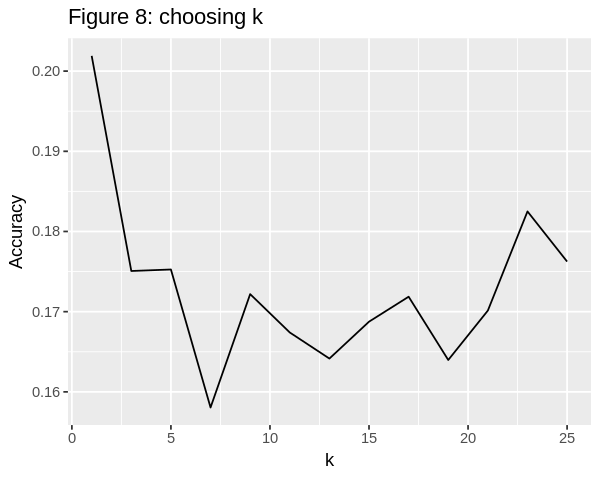

In [15]:
set.seed(151)
knn_cv_type1 <- train(x=X_train, y=Y_train_type1, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_type1
knn_plot <- knn_cv_type1$results %>%
    ggplot(aes(x=k,y=Accuracy)) +
    geom_line() +
    ggtitle('Figure 8: choosing k')
knn_plot

From the graph, we choose k=1 for the classification model for type 1.

In [15]:
set.seed(151)
final_k <- data.frame(k=1)
type1_model <- train(x=X_train,y=Y_train_type1,method='knn',tuneGrid=final_k)
type1_predictions <- predict(type1_model,X_test)
type1_results <- confusionMatrix(type1_predictions,Y_test_type1)
type1_results

Warning message:
“predictions failed for Resample02: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample06: k=1 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Confusion Matrix and Statistics

          Reference
Prediction Bug Dark Dragon Electric Fairy Fighting Fire Flying Ghost Grass
  Bug        3    0      0        0     0        0    0      0     0     0
  Dark       1    0      0        0     0        0    0      0     0     1
  Dragon     0    0      0        0     1        0    1      0     0     0
  Electric   0    1      0        0     0        0    4      0     0     0
  Fairy      0    0      0        0     2        0    0      0     0     0
  Fighting   1    0      0        0     0        0    2      0     0     0
  Fire       0    0      0        0     0        1    2      1     1     1
  Flying     1    0      0        1     0        0    0      0     0     0
  Ghost      0    1      0        0     0        0    0      0     2     0
  Grass      1    0      0        0     0        0    1      0     1     1
  Ground     1    0      0        0     0        1    0      0     0     3
  Ice        0    0      0        1     0      

Model 1 produces a test accuracy of 0.1375 when predicting Type 1.

### Outcome 3: Type 2

k-Nearest Neighbors 

640 samples
 12 predictor
 19 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Mono', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 574, 577, 576, 576, 577, 576, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa       
   1  0.3657883   0.123248110
   3  0.3748522   0.083577850
   5  0.4296420   0.102492288
   7  0.4562617   0.091445498
   9  0.4782396   0.089871933
  11  0.4610483   0.042962465
  13  0.4658087   0.024010351
  15  0.4750402   0.011669143
  17  0.4844182   0.018151950
  19  0.4906690   0.029064229
  21  0.4860288   0.015653571
  23  0.4860551   0.007001337
  25  0.4845167  -0.002179849

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 19.

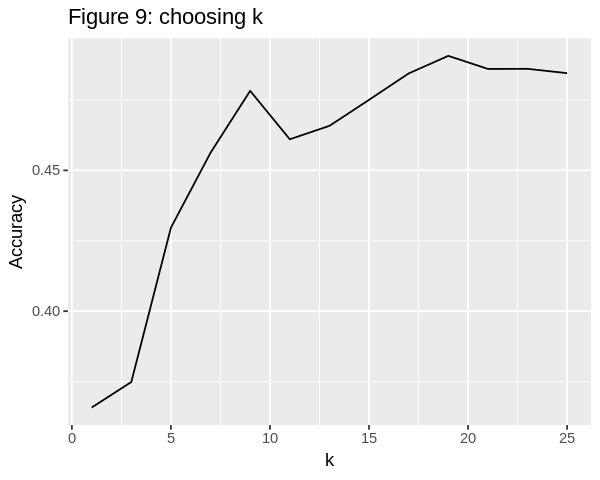

In [16]:
set.seed(151)
knn_cv_type2 <- train(x=X_train, y=Y_train_type2, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_type2
knn_plot <- knn_cv_type2$results %>%
    ggplot(aes(x=k,y=Accuracy)) +
    geom_line() +
    ggtitle('Figure 9: choosing k')
knn_plot

From the graph, we choose k=21 for the classification model for type 2.

In [17]:
set.seed(151)
final_k <- data.frame(k=21)
type2_model <- train(x=X_train,y=Y_train_type2,method='knn',tuneGrid=final_k)
type2_predictions <- predict(type2_model,X_test)
type2_results <- confusionMatrix(type2_predictions,Y_test_type2)
type2_results

Warning message:
“predictions failed for Resample18: k=21 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Confusion Matrix and Statistics

          Reference
Prediction Bug Dark Dragon Electric Fairy Fighting Fire Flying Ghost Grass
  Bug        0    0      0        0     0        0    0      0     0     0
  Dark       0    0      0        0     0        0    0      0     0     0
  Dragon     0    0      0        0     0        0    0      0     0     0
  Electric   0    0      0        0     0        0    0      0     0     0
  Fairy      0    0      0        0     0        0    0      0     0     0
  Fighting   0    0      0        0     0        0    0      0     0     0
  Fire       0    0      0        0     0        0    0      0     0     0
  Flying     0    0      0        0     0        0    0      0     0     0
  Ghost      0    0      0        0     0        0    0      0     0     0
  Grass      0    0      0        0     0        0    0      0     0     1
  Ground     0    0      0        0     0        0    0      0     0     0
  Ice        0    0      0        0     0      

Model 1 produces a test accuracy of 0.45 when predicting Type 2.

## Improving the models

The accuracy of our models in predicting the pokemon types is lower than we expected. We assumed that in using all of the attributes given we would get a better predicting model for all the pokemon Types and Legendary status. But from the results above, it is clear that the predictions for the Legendary status for each model was much higher compared to that of the Type predictions which was very low. We suspect that the variables used are just too similar among the pokemon that they fail to accurately distinguish between Type_1 and Type_2 pokemon.

To see if we could increase the accuracy of our models in predicting Types, we decided to use a subset of the x-variables based on those that differentiate between the mono and dual types best(i.e those that have a significant difference in the means). This process is shown below.

In [18]:
#trying to see if we can use a subset of the x-variables based on those that differentiate between 
#the mono and dual types best.(i.e those that have a significant difference in the means)
#All in an effort to see if we could have increased the accuracy of the prediction models
means <- scaled_pokemon %>% 
        group_by(Type_summary) %>%
        summarise(average_Hit_Points = mean(scaled_Hit_Points, trim = 0,na.rm = TRUE),
                average_attack = mean(scaled_Attack,trim = 0,na.rm = TRUE),
                average_defense = mean(scaled_Defense,trim = 0,na.rm = TRUE),
                average_SPattack = mean(scaled_Special_Attack,trim = 0,na.rm = TRUE),
                average_SPdefense = mean(scaled_Special_Defense,trim = 0,na.rm = TRUE),
                average_speed = mean(scaled_Speed,trim = 0,na.rm = TRUE),
                average_Gen1 = mean(scaled_Gen_1,trim = 0,na.rm = TRUE),
                average_Gen2 = mean(scaled_Gen_2,trim = 0,na.rm = TRUE),
                average_Gen3 = mean(scaled_Gen_3,trim = 0,na.rm = TRUE),
                average_Gen4 = mean(scaled_Gen_4,trim = 0,na.rm = TRUE),
                average_Gen5 = mean(scaled_Gen_5,trim = 0,na.rm = TRUE),
                average_Gen6 = mean(scaled_Gen_6,trim = 0,na.rm = TRUE))
        
means
#Gen2 and Gen3 seem to have the smallest difference in means but removing them only would make the model inaccurate because
#we would still be including the other generations' data. To combat this we would have to remove all generation column data...
#so lets try that.

Type_summary,average_Hit_Points,average_attack,average_defense,average_SPattack,average_SPdefense,average_speed,average_Gen1,average_Gen2,average_Gen3,average_Gen4,average_Gen5,average_Gen6
Dual,0.9565802,0.9733111,0.9934774,0.9646018,0.9795600,0.9497676,0.4133459,0.3647395,0.4426158,0.4158677,0.4358579,0.3769955
Mono,0.9175462,0.8721111,0.8427178,0.8548898,0.8811554,0.8873214,0.5001666,0.3627466,0.4515654,0.3594903,0.4731755,0.2587791


### Model 2: Training k-nn classification model on Stats only

In [18]:
#knn using full data (model 1)

X_train2 <- scaled_pokemon %>% 
    select(scaled_Hit_Points, scaled_Attack, scaled_Defense, scaled_Special_Attack, 
           scaled_Special_Defense, scaled_Speed) %>% 
    slice(training_rows) %>% 
    data.frame()


X_test2 <- scaled_pokemon %>% 
    select(scaled_Hit_Points, scaled_Attack, scaled_Defense, scaled_Special_Attack, 
           scaled_Special_Defense, scaled_Speed) %>% 
    slice(-training_rows) %>% 
    data.frame()

ks <- data.frame(k=c(1,3,5,7,9,11,13,15,17,19,21,23,25))
train_control <- trainControl(method='cv', number=10)

### Outcome 1: Legendary Status

k-Nearest Neighbors 

640 samples
  6 predictor
  2 classes: 'False', 'True' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 576, 577, 576, 576, 576, 576, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.9374481  0.5681775
   3  0.9343464  0.5192074
   5  0.9407204  0.5326662
   7  0.9343471  0.4934034
   9  0.9343712  0.5011486
  11  0.9406212  0.5465775
  13  0.9406212  0.5306384
  15  0.9437958  0.5183326
  17  0.9437958  0.5118944
  19  0.9484833  0.5211694
  21  0.9468960  0.5128980
  23  0.9437710  0.4775516
  25  0.9422333  0.4592670

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 19.

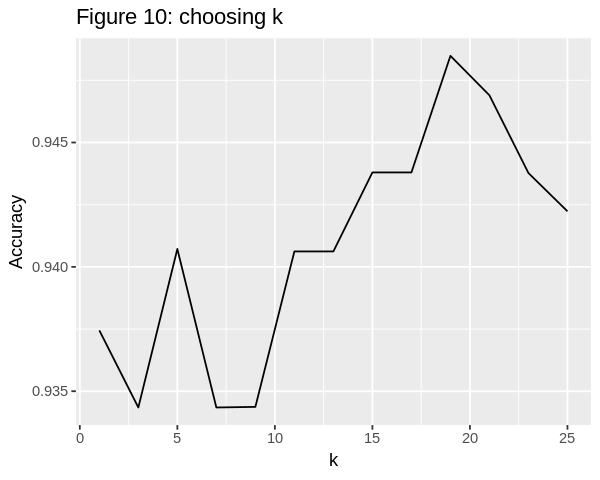

In [19]:
set.seed(151)
knn_cv_legendary <- train(x=X_train2, y=Y_train_legendary, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_legendary
knn_plot <- knn_cv_legendary$results %>%
    ggplot(aes(x=k,y=Accuracy)) +
    geom_line() +
    ggtitle('Figure 10: choosing k')
knn_plot

From the graph, we choose k=19 for the classification model for Legendary.

In [21]:
set.seed(151)
final_k <- data.frame(k=19)
legendary_model <- train(x=X_train,y=Y_train_legendary,method='knn',tuneGrid=final_k)
legendary_predictions <- predict(legendary_model,X_test)
legendary_results <- confusionMatrix(legendary_predictions,Y_test_legendary)
legendary_results

Confusion Matrix and Statistics

          Reference
Prediction False True
     False   147   12
     True      0    1
                                          
               Accuracy : 0.925           
                 95% CI : (0.8727, 0.9606)
    No Information Rate : 0.9188          
    P-Value [Acc > NIR] : 0.458418        
                                          
                  Kappa : 0.1328          
 Mcnemar's Test P-Value : 0.001496        
                                          
            Sensitivity : 1.00000         
            Specificity : 0.07692         
         Pos Pred Value : 0.92453         
         Neg Pred Value : 1.00000         
             Prevalence : 0.91875         
         Detection Rate : 0.91875         
   Detection Prevalence : 0.99375         
      Balanced Accuracy : 0.53846         
                                          
       'Positive' Class : False           
                                          

Model 2 produces a test accuracy of 0.925 when predicting Legendary status.

### Outcome 2: Type 1

k-Nearest Neighbors 

640 samples
  6 predictor
 18 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 579, 576, 575, 576, 578, 577, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.1980172  0.1312199
   3  0.1932653  0.1255295
   5  0.1938836  0.1209798
   7  0.2238721  0.1504889
   9  0.2124234  0.1361851
  11  0.2187952  0.1413191
  13  0.2252498  0.1452972
  15  0.2312571  0.1491950
  17  0.2142117  0.1297412
  19  0.2234354  0.1372302
  21  0.2343315  0.1479411
  23  0.2297202  0.1428433
  25  0.2297712  0.1422208

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 21.

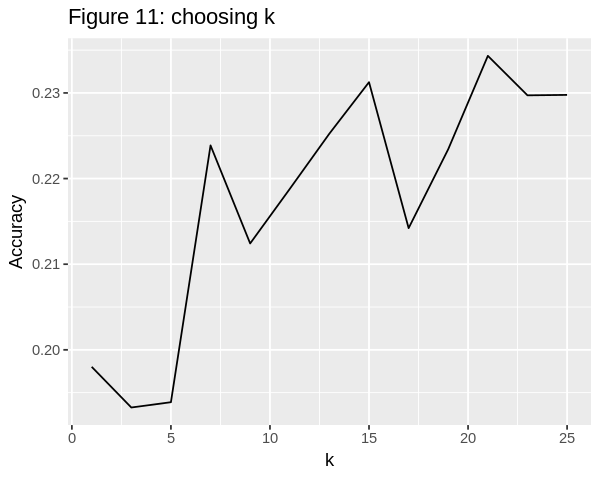

In [20]:
set.seed(151)
knn_cv_type1 <- train(x=X_train2, y=Y_train_type1, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_type1
knn_plot <- knn_cv_type1$results %>%
    ggplot(aes(x=k,y=Accuracy)) +
    geom_line() +
    ggtitle('Figure 11: choosing k')
knn_plot

From the graph, we choose k=21 for the classification model for Type 1.

In [23]:
set.seed(151)
final_k <- data.frame(k=21)
type1_model <- train(x=X_train2,y=Y_train_type1,method='knn',tuneGrid=final_k)
type1_predictions <- predict(type1_model,X_test2)
type1_results <- confusionMatrix(type1_predictions,Y_test_type1)
type1_results

Warning message:
“predictions failed for Resample02: k=21 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message:
“predictions failed for Resample06: k=21 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Confusion Matrix and Statistics

          Reference
Prediction Bug Dark Dragon Electric Fairy Fighting Fire Flying Ghost Grass
  Bug        6    0      0        0     0        0    0      0     3     0
  Dark       0    0      0        1     0        0    0      0     0     0
  Dragon     0    0      0        0     0        0    1      0     0     0
  Electric   0    0      0        0     0        0    3      0     1     0
  Fairy      0    0      0        0     0        0    0      0     0     0
  Fighting   0    0      0        0     0        0    0      0     0     0
  Fire       1    0      1        1     0        0    6      1     0     1
  Flying     0    0      0        0     0        0    0      0     0     0
  Ghost      0    1      0        0     0        0    0      0     1     1
  Grass      0    0      0        0     1        0    1      0     1     0
  Ground     0    0      0        0     0        2    0      0     0     0
  Ice        0    0      0        0     0      

Model 2 produces a test accuracy of 0.2438 when predicting Type 1.

### Outcome 3: Type 2

k-Nearest Neighbors 

640 samples
  6 predictor
 19 classes: 'Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Mono', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 574, 577, 576, 576, 577, 576, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa       
   1  0.3171990  0.0647612926
   3  0.3596413  0.0744781646
   5  0.4171014  0.0731765937
   7  0.4562661  0.0862208422
   9  0.4640554  0.0652937942
  11  0.4765561  0.0738520392
  13  0.4701603  0.0449927908
  15  0.4656419  0.0187919391
  17  0.4735273  0.0186428692
  19  0.4736009  0.0105158517
  21  0.4719671  0.0000484323
  23  0.4781697  0.0054259795
  25  0.4844197  0.0093365321

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 25.

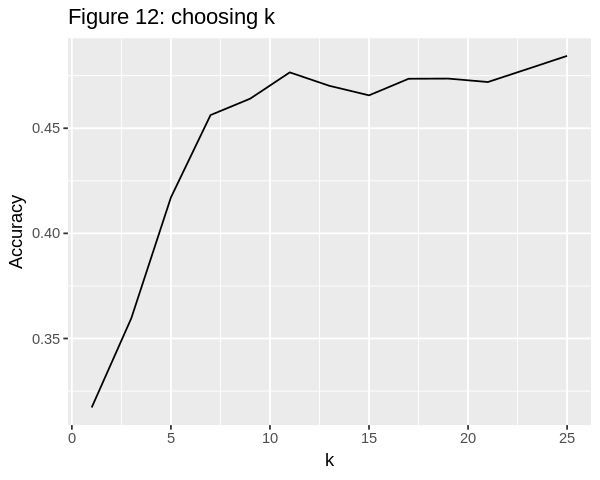

In [21]:
set.seed(151)
knn_cv_type2 <- train(x=X_train2, y=Y_train_type2, method='knn', tuneGrid=ks, trControl=train_control)
knn_cv_type2
knn_plot <- knn_cv_type2$results %>%
    ggplot(aes(x=k,y=Accuracy)) +
    geom_line() +
    ggtitle('Figure 12: choosing k')
knn_plot

From the graph, we choose k=25 for the classification model for Type 2.

In [25]:
set.seed(151)
final_k <- data.frame(k=25)
type2_model <- train(x=X_train2,y=Y_train_type2,method='knn',tuneGrid=final_k)
type2_predictions <- predict(type2_model,X_test2)
type2_results <- confusionMatrix(type2_predictions,Y_test_type2)
type2_results

Warning message:
“predictions failed for Resample18: k=25 Error in dimnames(x) <- dn : 
  length of 'dimnames' [2] not equal to array extent
”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Confusion Matrix and Statistics

          Reference
Prediction Bug Dark Dragon Electric Fairy Fighting Fire Flying Ghost Grass
  Bug        0    0      0        0     0        0    0      0     0     0
  Dark       0    0      0        0     0        0    0      0     0     0
  Dragon     0    0      0        0     0        0    0      0     0     0
  Electric   0    0      0        0     0        0    0      0     0     0
  Fairy      0    0      0        0     0        0    0      0     0     0
  Fighting   0    0      0        0     0        0    0      0     0     0
  Fire       0    0      0        0     0        0    0      0     0     0
  Flying     0    1      0        0     0        0    0      0     0     0
  Ghost      0    0      0        0     0        0    0      0     0     0
  Grass      0    0      0        0     0        0    0      0     0     0
  Ground     0    0      0        0     0        0    0      0     0     0
  Ice        0    0      0        0     0      

Model 2 produces a test accuracy of 0.4628 when predicting Type 2.

## Discussion

Model 2, which does not include Generation number, improves on test accuracy when predicting Type 1 (0.1375 to 0.2438) and Type 2 (0.45 to 0.4628), but not when predicting Legendary status (0.9438 to 0.925).

Overall, we settled on Model 2 because the improvements from removing Generation number from the classification model outweigh the setbacks. Furthermore, since we are designing a model that will be able to predict the Legendary status and Type(s) for a new generation of Pokemon, it stands that Generation number is not a good predictor since new Pokemon will have a new Generation number.  

As we expected, Model 2 predicts Legendary status well with a test accuracy of 0.925. Likewise, we also expected the test accuracy for predicting Type 1 and Type 2 to be relatively low given that there are 18 and 19 possible outcomes respectively, with very similar Stats values between them. Nevertheless, we were pleased to find that the two classification model still perform better than chance with test accuracies of 0.2438 and 0.4628 respectively.

These models can help fans of the Pokémon franchise predict the Types and Legendary-status of new Pokémon in the upcoming games. 

## References

[1] Websster,A. (2019, February 27). Pokemon Sword and Shield are coming to the Switch this year. Retreived from https://www.theverge.com/2019/2/27/18241239/nintendo-switch-pokemon-sword-and-shield-launch-announcement

[2]Timbers,T.A., Lee, M.,& Hinshaw,S.(2019,March 26). Introduction to Data Science. Retrieved April 5, 2019, from  https://ubc-dsci.github.io/introduction-to-datascience/classification-continued.html#scaling-your-data